## Let's create a graph

In [11]:
from raphtory import graph_loader
from raphtory import Graph
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [12]:
g = Graph()
g.add_edge("2021-01-01 12:32:00", "Ben", "Hamza", {"type": "friend"})
g.add_edge("2021-01-02 14:15:36", "Hamza", "Haaroon", {"type": "friend"})
print("Total vertices in the graph:", g.num_vertices())
print("Total vertices at 2021-01-01 12:40:00:", g.at("2021-01-01 12:40:00").num_vertices())


Total vertices in the graph: 3
Total vertices at 2021-01-01 12:40:00: 2


## Adding some vertex history

In [13]:
g = Graph()
g.add_vertex(timestamp=1, id="ben", properties={"property 1": 1, "property 3": "hi", "property 4": True})
g.add_vertex(timestamp=2, id="ben", properties={"property 1": 2, "property 2": 0.6, "property 4": False})
g.add_vertex(timestamp=3, id="ben", properties={"property 2": 0.9, "property 3": "hello", "property 4": True})

g.add_vertex_properties(id="ben", properties={"unchanging property": 123})

print(g.vertex("ben").properties.temporal.get("property 1").items())
print(g.vertex("ben").properties.constant.get("unchanging property"))

[(1, 1), (2, 2)]
123


## Adding some edge history

In [14]:

g.add_vertex(timestamp=1,id="hamza")
g.add_edge(timestamp=1, src="ben", dst="hamza", properties={"property 1": 1, "property 3": "hi", "property 4": True})
g.add_edge(timestamp=2, src="ben", dst="hamza", properties={"property 1": 2, "property 2": 0.6, "property 4": False})
g.add_edge(timestamp=3, src="ben", dst="hamza", properties={"property 2": 0.9, "property 3": "hello", "property 4": True})

g.add_edge_properties(src="ben", dst="hamza", properties={"static property": 123})

g.edge("ben","hamza")

Edge(source=ben, target=hamza, earliest_time=1, latest_time=3, properties={Properties({property 1: 2, property 3: hello, property 4: true, property 2: 0.9, static property: 123})})

## Loading a real graph

In the cell below we are pulling the subreddit to subreddit hyperlink graph from the [SNAP data repository](http://snap.stanford.edu/data/soc-RedditHyperlinks.html). This builds a web of the references between different communities on reddit with NLP analysis on each post (edge/link) providing properties such as sentiment.

In [15]:
import requests
import pandas as pd
import os

url = "http://snap.stanford.edu/data/soc-redditHyperlinks-title.tsv"
file_path = "soc-redditHyperlinks-title.tsv"

if not os.path.exists(file_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  
    downloaded_size = 0

    with open(file_path, "wb") as f:
        for data in response.iter_content(block_size):
            f.write(data)
            downloaded_size += len(data)
            progress = (downloaded_size / total_size) * 100
            print(f"Downloaded {downloaded_size}/{total_size} bytes ({progress:.2f}%)", end='\r')

    print("\nFile downloaded successfully.")

df = pd.read_csv(file_path, sep='\t')


Next we label all the nlp features from the 'properties' column and make them there own columns which we can reference in the Raphtory Pandas loader 

In [16]:
#Define all the features as per the spec on the SNAP website
features = [
    "number_of_characters", "number_of_characters_without_counting_whitespace", "fraction_of_alphabetical_characters", 
    "fraction_of_digits", "fraction_of_uppercase_characters", "fraction_of_white_spaces", "fraction_of_special_characters", 
    "number_of_words", "number_of_unique_words", "number_of_long_words_at_least_6_characters", "average_word_length", 
    "number_of_unique_stopwords", "fraction_of_stopwords", "number_of_sentences", "number_of_long_sentences_at_least_10_words", 
    "average_number_of_characters_per_sentence", "average_number_of_words_per_sentence", "automated_readability_index", 
    "positive_sentiment", "negative_sentiment", "compound_sentiment", 
    "liwc_funct", "liwc_pronoun", "liwc_ppron", "liwc_i", "liwc_we", "liwc_you", "liwc_she_he", "liwc_they", 
    "liwc_ipron", "liwc_article", "liwc_verbs", "liwc_aux_vb", "liwc_past", "liwc_present", "liwc_future", 
    "liwc_adverbs", "liwc_prep", "liwc_conj", "liwc_negate", "liwc_quant", "liwc_numbers", "liwc_swear", 
    "liwc_social", "liwc_family", "liwc_friends", "liwc_humans", "liwc_affect", "liwc_posemo", "liwc_negemo", 
    "liwc_anx", "liwc_anger", "liwc_sad", "liwc_cog_mech", "liwc_insight", "liwc_cause", "liwc_discrep", 
    "liwc_tentat", "liwc_certain", "liwc_inhib", "liwc_incl", "liwc_excl", "liwc_percept", "liwc_see", 
    "liwc_hear", "liwc_feel", "liwc_bio", "liwc_body", "liwc_health", "liwc_sexual", "liwc_ingest", 
    "liwc_relativ", "liwc_motion", "liwc_space", "liwc_time", "liwc_work", "liwc_achiev", "liwc_leisure", 
    "liwc_home", "liwc_money", "liwc_relig", "liwc_death", "liwc_assent", "liwc_dissent", "liwc_nonflu", "liwc_filler"
]

# Convert the property string to arrays of integers
df['PROPERTIES'] = df['PROPERTIES'].str.split(',').apply(lambda x: [float(i) for i in x])
# Convert the 'properties' column into a DataFrame with individual columns
properties_df = df['PROPERTIES'].apply(pd.Series)
# Rename the columns using the features array
properties_df.columns = features
# Concatenate the original DataFrame and the properties DataFrame
df = pd.concat([df, properties_df], axis=1)
# Drop the original 'properties' column
df = df.drop(columns=['PROPERTIES'])
#Convert the datestrings to datetimes
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
# Convert datetime to millisecond precision (datetime64[ms])
df['TIMESTAMP'] = df['TIMESTAMP'].astype('datetime64[ms]')

df.head()


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,number_of_characters,number_of_characters_without_counting_whitespace,fraction_of_alphabetical_characters,fraction_of_digits,fraction_of_uppercase_characters,...,liwc_achiev,liwc_leisure,liwc_home,liwc_money,liwc_relig,liwc_death,liwc_assent,liwc_dissent,liwc_nonflu,liwc_filler
0,rddtgaming,rddtrust,1u4pzzs,2013-12-31 16:39:18,1,25.0,23.0,0.760000,0.00,0.440000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,xboxone,battlefield_4,1u4tmfs,2013-12-31 17:59:11,1,100.0,88.0,0.780000,0.02,0.080000,...,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ps4,battlefield_4,1u4tmos,2013-12-31 17:59:40,1,100.0,88.0,0.780000,0.02,0.080000,...,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,fitnesscirclejerk,leangains,1u50xfs,2013-12-31 19:01:56,1,49.0,43.0,0.775510,0.00,0.265306,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,fitnesscirclejerk,lifeprotips,1u51nps,2013-12-31 21:02:28,1,14.0,14.0,0.785714,0.00,0.428571,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now let's load this data into a Raphtory graph - we won't use all the features, just grab a couple for demo purposes, but obviously you can edit the code below to choose the ones you are interested in.

In [17]:
reddit_graph = Graph.load_from_pandas(edges_df=df,src="SOURCE_SUBREDDIT",dst="TARGET_SUBREDDIT",time="TIMESTAMP",props=["number_of_unique_words", "average_word_length", "number_of_unique_stopwords", "number_of_sentences", "automated_readability_index",  "positive_sentiment", "negative_sentiment", "compound_sentiment"])
print(reddit_graph)

Graph(number_of_edges=234792, number_of_vertices=54075, earliest_time=1388506820000, latest_time=1493570870000)


In [19]:
edge = reddit_graph.edge("conspiracy","documentaries")
print("property names:",edge.properties.keys())
print("sentiment history:",edge.properties.temporal.get("compound_sentiment").items())

date="2014-10-30 13:45:00"
edge_perspective = reddit_graph.at(date).edge("conspiracy","documentaries")
print("Most recent sentiment on",date,"-",edge_perspective["compound_sentiment"])

reddit_graph.vertex("conspiracy").out_neighbours().out_neighbours().out_neighbours()

property names: ['number_of_unique_words', 'average_word_length', 'number_of_unique_stopwords', 'number_of_sentences', 'automated_readability_index', 'positive_sentiment', 'negative_sentiment', 'compound_sentiment']
sentiment history: [(1404952792000, 0.2732), (1414676601000, 0.2344), (1418639874000, 0.0), (1420030124000, -0.2481), (1426362695000, 0.0), (1427198700000, -0.2023), (1427894452000, 0.0), (1429187302000, 0.5562), (1429644527000, 0.296), (1431911341000, -0.3595), (1433653011000, -0.34), (1435258425000, 0.0772), (1439068701000, -0.5574), (1439249314000, 0.0), (1440456620000, 0.4019), (1446586617000, 0.0), (1447125847000, -0.7042), (1447422296000, 0.0387), (1450563607000, 0.8192), (1450658697000, 0.6841), (1450863723000, 0.2732), (1451249771000, -0.4767), (1455119795000, 0.0), (1455295188000, -0.4939), (1456505801000, -0.6908), (1456949833000, 0.0), (1458061181000, 0.3384), (1460498612000, -0.5267), (1461879765000, -0.6136), (1463741129000, 0.0), (1466862772000, -0.1779), (147

PathFromVertex(Vertex(name=cancer, properties={_id: cancer}), Vertex(name=soccer, properties={_id: soccer}), Vertex(name=pics, properties={_id: pics}), Vertex(name=funny, properties={_id: funny}), Vertex(name=bitcoin, properties={_id: bitcoin}), Vertex(name=propaganda, properties={_id: propaganda}), Vertex(name=conspiracy, properties={_id: conspiracy}), Vertex(name=askreddit, properties={_id: askreddit}), Vertex(name=trees, properties={_id: trees}), Vertex(name=cricket, properties={_id: cricket}), ...)

## Let's have a look at the daily traffic

1217it [01:40, 12.12it/s]


<Axes: xlabel='Time', ylabel='Interactions'>

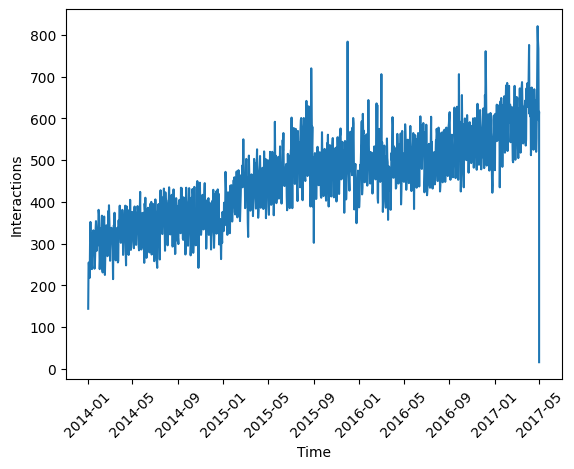

In [20]:
from tqdm import tqdm
views = reddit_graph.rolling(window="1 day") 

timestamps   = []
edge_count   = []

for view in tqdm(views):
    timestamps.append(view.latest_date_time())
    edge_count.append(view.num_edges())            

sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Interactions")
sns.lineplot(x = timestamps, y = edge_count,ax=ax)

## Average Weekly sentiment for a given subreddit

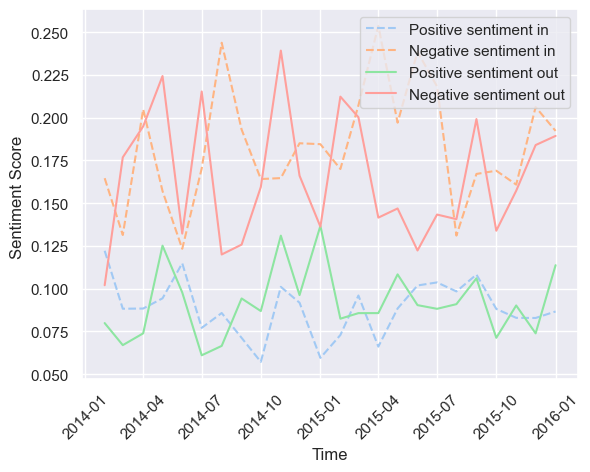

In [31]:
views = reddit_graph.window("2014-01-01 00:00:00","2016-01-01 00:00:00").vertex("conspiracy").rolling("1 month") 
timestamps             = []
positive_sentiment_in  = []
positive_sentiment_out = []
negative_sentiment_in  = []
negative_sentiment_out = []

def weighted_average_degree(vertex,prop_name,incoming):
    edges = vertex.in_edges() if incoming else vertex.out_edges()
    total_weight=0
    for edge_weights in edges.properties.temporal.get(prop_name).values():
        total_weight+= sum(edge_weights)
    return total_weight / max(1,len(list(edges)))

for vertex in views:
    timestamps.append(vertex.latest_date_time())
    positive_sentiment_in.append(weighted_average_degree(vertex,"positive_sentiment",incoming=True))
    positive_sentiment_out.append(weighted_average_degree(vertex,"positive_sentiment",incoming=False))
    negative_sentiment_in.append(weighted_average_degree(vertex,"negative_sentiment",incoming=True))
    negative_sentiment_out.append(weighted_average_degree(vertex,"negative_sentiment",incoming=False))        

sns.set()
sns.set_palette("pastel")
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Sentiment Score ")

sns.lineplot(x = timestamps, y = positive_sentiment_in,ax=ax,label="Positive sentiment in",linestyle="--")
sns.lineplot(x = timestamps, y = negative_sentiment_in,ax=ax,label ="Negative sentiment in",linestyle="--")
sns.lineplot(x = timestamps, y = positive_sentiment_out,ax=ax,label="Positive sentiment out")
sns.lineplot(x = timestamps, y = negative_sentiment_out,ax=ax,label ="Negative sentiment out")
ax.legend(loc="best")


## Running some example algorithms

### Lets get the top 5 subreddits in the graph as per pagerank

In [50]:
from raphtory import algorithms as algos

#First lets run the algorithm and get our result set
result_set=algos.pagerank(reddit_graph)

#We can then have a look at the values of specific nodes
print("The conspiracy subreddit has a pagerank score of",result_set.get('conspiracy'))

#Convert the results to a dataframe
print(result_set.to_df().sort_values(by='Value',ascending=False).head())

#get the top 5 most import users via the intial top_k function
print("The top five ranked subreddits are ",result_set.top_k(5))


The conspiracy subreddit has a pagerank score of 0.0028709357281156145
             Key     Value
11436  askreddit  0.019556
23584       iama  0.015616
6684        pics  0.009884
30291      funny  0.009283
910       videos  0.006105
The top five ranked subreddits are  [('askreddit', 0.019555592169738754), ('iama', 0.01561587791951029), ('pics', 0.009884204062062652), ('funny', 0.009282589235120708), ('videos', 0.006105153065518092)]


### Getting the largest connected component

In [103]:
#First lets run the algorithm and group by the component_id
components=algos.weakly_connected_components(reddit_graph).group_by()

#Map the returned dict so that we have the size of the components instead of the vertex names
component_sizes = {key: len(value) for key, value in components.items()}
#Get the component id with the greatest number of nodes
component_with_biggest_size = max(component_sizes,key=component_sizes.get)
#Get the value of this component
lcc=component_sizes[component_with_biggest_size]
print("The largest component has",lcc,"nodes out of a total of",reddit_graph.num_vertices())

The largest component has 52468 nodes out of a total of 54075
